# Lab03: Machine learning

- MSSV: 1712379
- Họ và tên: Đặng Thành Duy

## Yêu cầu bài tập

**Cách làm bài**


Bạn sẽ làm trực tiếp trên file notebook này; trong file, từ `TODO` để cho biết những phần mà bạn cần phải làm.

Bạn có thể thảo luận ý tưởng cũng như tham khảo các tài liệu, nhưng *code và bài làm phải là của bạn*. 

Nếu vi phạm thì sẽ bị 0 điểm cho bài tập này.

**Cách nộp bài**

Trước khi nộp bài, rerun lại notebook (`Kernel` -> `Restart & Run All`).

Sau đó, tạo thư mục có tên `MSSV` của bạn (vd, nếu bạn có MSSV là 1234567 thì bạn đặt tên thư mục là `1234567`) Chép file `Lab03-Clustering.ipynb` vào, rồi nén thư mục `MSSV` này lại và nộp ở link trên moodle.

**Nội dung bài tập**

Bài tập 3 là bài tập cá nhân. Trong bài này, bạn sẽ cài đặt 2 thuật toán học máy: 
1. Cây quyết định (Decision tree)
2. Gaussian Naive Bayes (Lớp CNTN sẽ làm thêm phần 2)

### Import library

In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

### Load Iris dataset

In [2]:
from sklearn.model_selection import train_test_split
iris=datasets.load_iris()

X=iris.data
y=iris.target

#split dataset into training data and testing data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33, random_state=42)


## 1. Cây quyết định: Iterative Dichotomiser 3 (ID3)

### 1.1 Information Gain

Thông tin kỳ vọng (entropy):

$$Entropy=-\sum_{i}^{n}p_ilog_{2}(p_i)$$

Hàm entropy đạt giá trị nhỏ nhất nếu có một giá trị $p_i=1$, đạt giá trị lớn nhất nếu tất cả các $p_i$ bằng nhau. Những tính chất này của hàm entropy khiến nó được sử dụng trong việc đo độ hỗn loạn của một phép phân chia của ID3.

In [3]:
def entropy(counts, n_samples):
    """
    Parameters:
    -----------
    counts: shape (n_classes): list number of samples in each class
    n_samples: number of data samples
    
    -----------
    return entropy 
    """
    #TODO
    e = 0
    for c in counts:
        if c != 0:
            e = e - c/n_samples*np.log2(c/n_samples)
    return e


In [4]:
def entropy_of_one_division(division): 
    """
    Returns entropy of a divided group of data
    Data may have multiple classes
    """
    n_samples = len(division)
    n_classes = set(division)
    
    counts=[]
    #count samples in each class then store it to list counts
    #TODO:
    for cl in n_classes:
        temp = np.count_nonzero(division==cl)
        counts.append(temp)
    
    return entropy(counts,n_samples),n_samples


def get_entropy(y_predict, y):
    """
    Returns entropy of a split
    y_predict is the split decision by cutoff, True/Fasle
    """
    n = len(y)
    entropy_true, n_true = entropy_of_one_division(y[y_predict]) # left hand side entropy
    entropy_false, n_false = entropy_of_one_division(y[~y_predict]) # right hand side entropy
    # overall entropy
    #TODO s=?
    s = n_true/n*entropy_true+n_false/n*entropy_false
    return s

Độ lợi thông tin phân lớp tập D theo thuộc tính A:
$$ Gain(A)=Entrophy(D)-Entrophy_{A}(D)$$

Trong ID3, tại mỗi node, thuộc tính được chọn được xác định dựa trên là thuộc tính khiến cho information gain đạt giá trị lớn nhất.

Các thuộc tính của tập Iris đều có giá trị liên tục. Do đó ta cần rời rạc hóa cho từng thuộc tính. Cách đơn giản là sử dụng một ngưỡng `cutoff` chia giá trị của dữ liệu trên mỗi thuộc tính sẽ làm 2 phần: `<cutoff` và `>=cutoff`.

Để tìm ngưỡng `cutoff` tốt nhất cho mỗi thuộc tính ta lần lượt thay `cutoff` bằng các giá trị của thuộc tính sau đó tính entropy, `cutoff` tốt nhất khi entropy bé nhất $ \left(\arg\min Entrophy_{A}(D)\right)$.  

### 1.2 Decision tree

In [5]:
class DecisionTreeClassifier:
    def __init__(self, tree=None, depth=0):
        '''Parameters:
        -----------------
        tree: decision tree
        depth: depth of decision tree after training'''
        
        self.depth = depth
        self.tree=tree
    def fit(self, X, y, node={}, depth=0):
        '''Parameter:
        -----------------
        X: training data
        y: label of training data
        ------------------
        return: node 
        
        node: each node represented by cutoff value and column index, value and children.
         - cutoff value is thresold where you divide your attribute
         - column index is your data attribute index
         - value of node is mean value of label indexes, 
           if a node is leaf all data samples will have same label
        
        Note that: we divide each attribute into 2 part => each node will have 2 children: left, right.
        '''
        
        #Stop conditions
        
        #if all value of y are the same 
        if np.all(y==y[0]):
            return {'val':y[0]}

        else: 
            col_idx, cutoff, entropy = self.find_best_split_of_all(X, y)    # find one split given an information gain 
            y_left = y[X[:, col_idx] < cutoff]
            y_right = y[X[:, col_idx] >= cutoff]
            node = {'index_col':col_idx,
                        'cutoff':cutoff,
                   'val':np.mean(y)}
            node['left'] = self.fit(X[X[:, col_idx] < cutoff], y_left, {}, depth+1)
            node['right'] = self.fit(X[X[:, col_idx] >= cutoff], y_right, {}, depth+1)
            self.depth += 1 
            self.tree = node
            return node
    
    def find_best_split_of_all(self, X, y):
        col_idx = None
        min_entropy = 1
        cutoff = None
        for i, col_data in enumerate(X.T):
            entropy, cur_cutoff = self.find_best_split(col_data, y)
            if entropy == 0:                   #best entropy
                return i, cur_cutoff, entropy
            elif entropy <= min_entropy:
                min_entropy = entropy
                col_idx = i
                cutoff = cur_cutoff
               
        return col_idx, cutoff, min_entropy
    
    def find_best_split(self, col_data, y):
        ''' Parameters:
        -------------
        col_data: data samples in column'''
         
        min_entropy = 10

        #Loop through col_data find cutoff where entropy is minimum
        
        for value in set(col_data):
            y_predict = col_data < value
            my_entropy = get_entropy(y_predict, y)
            #TODO
            #min entropy=?, cutoff=?
            if my_entropy < min_entropy:
                min_entropy = my_entropy
                cutoff = value
            
        return min_entropy, cutoff
                                               
    def predict(self, X):
        tree = self.tree
        pred = np.zeros(shape=len(X))
        for i, c in enumerate(X):
            pred[i] = self._predict(c)
        return pred
    
    def _predict(self, row):
        cur_layer = self.tree
        while cur_layer.get('cutoff'):
            if row[cur_layer['index_col']] < cur_layer['cutoff']:
                cur_layer = cur_layer['left']
            else:
                cur_layer = cur_layer['right']
        else:
            return cur_layer.get('val')

### 1.3 Classification on Iris Dataset

In [6]:
model = DecisionTreeClassifier()
tree = model.fit(X_train, y_train)
pred=model.predict(X_train)
print('Accuracy of your decision tree model on training data:', accuracy_score(y_train,pred))
pred=model.predict(X_test)
print('Accuracy of your decision tree model:', accuracy_score(y_test,pred))


Accuracy of your decision tree model on training data: 1.0
Accuracy of your decision tree model: 0.96


## 2. Định lý Bayes

Định lý Bayes được phát biểu dưới dạng toán học như sau:
$$\begin{equation}
P\left(A|B\right)= \dfrac{P\left(B|A\right)P\left(A\right)}{P\left(B\right)}
\end{equation}$$

Nếu ta coi $B$ là dữ liệu $\mathcal{D}$, các thông số cần ước tính $A$ là $w$, ta có:

$$ \begin{align}
    \underbrace{P(w|\mathcal{D})}_{Posterior}= \dfrac{1}{\underbrace{P(\mathcal{D})}_{Normalization}} \overbrace{P(\mathcal{D}|w)}^{\text{Likelihood}} \overbrace{P(w)}^{Prior}
    \end{align}
$$

#### Naive Bayes
Để giúp cho việc tính toán được đơn giản, người ta thường giả sử một cách đơn giản nhất rằng các thành phần của biến ngẫu nhiên $D$ (hay các thuộc tính của dữ liệu $D$) là độc lập với nhau, nếu biết $w$. Tức là:
$$P(\mathcal{D}|w)=\prod _{i=1}^{d}P(x_i|w)$$

$d$: số lượng thuộc tính


### 2.1. Probability Density Function

In [7]:
class pdf:
    def __init__(self,hist=None):
        '''
        A probability density function represented by a histogram
        
        hist: shape (n,1), n: number of hypotheses
        hypo: hypothesis (simply understand as label)
        ------------------
        hist[hypo]=P(hypo)
        '''
        self.hist = hist
        
    #virtual function
    def likelihood(self, data, hypo):
        '''Paramters:
        data: new data record 
        hypo: hypothesis (simply understand as label)
        ---------
        return P(data/hypo)
        ''' 
        raise Exception()
            
    #update histogram for new data 
    def update(self, data):
        ''' 
        P(hypo/data)=P(data/hypo)*P(hypo)*(1/P(data))
        '''
        
        #Likelihood * Prior 
        #TODO
        for hypo in self.hist.keys():
            #self.hist[hypo]=?
            self.hist[hypo] = self.hist[hypo]*self.likelihood(data,hypo)
            
        #Normalization
        
        #TODO: s=P(data)
        #s=?
        s = sum(self.hist.values())
        for hypo in self.hist.keys():
            self.hist[hypo] = self.hist[hypo]/s
        
    def plot_pdf(self):
        #plot Histogram
        #TODO
        plt.bar(self.hist.keys(),self.hist.values())
    
    def maxHypo(self):
        #find the hypothesis with maximum probability from hist
        #TODO
        max_hypo_name = 0
        max_hypo_value = 0
        key = self.hist.keys()
        value = self.hist.values()
        for k,v in zip(key,value):
            if max_hypo_value < v:
                max_hypo_value = v
                max_hypo_name = k
        return max_hypo_name



### 2.2 Classification on Iris Dataset

#### Gaussian Naive Bayes

- Naive Bayes có thể được mở rộng cho dữ liệu với các thuộc tính có giá trị là số thực, phổ biến nhất bằng cách sử dụng phân phối chuẩn (Gaussian distribution).

- Phần mở rộng này được gọi là Gaussian Naive Bayes. Các hàm khác có thể được sử dụng để ước tính phân phối dữ liệu, nhưng Gauss (hoặc phân phối chuẩn) là dễ nhất để làm việc vì chỉ cần ước tính giá trị trung bình và độ lệch chuẩn từ dữ liệu huấn luyện.

#### Define Gauss function

$$ f\left(x;\mu,\sigma \right)= \dfrac{1}{\sigma \sqrt{2\pi}} 
\exp \left({-\dfrac{\left(x-\mu\right)^2}{2 \sigma^2}}\right) $$

In [8]:
def Gauss(std,mean,x):
    #Calculate the Gaussian probability distribution function for x
    #TODO 
    p = np.exp(-(float(x)-float(mean))**2/(2*std**2))/(((2*np.pi)**.5)*std)
    return p


In [9]:
class NBGaussian(pdf):
    def __init__(self, hist=None, std=None, mean=None):
        '''Parameters:
        
        '''
        pdf.__init__(self, hist)
        self.std=std
        self.mean=mean
    def likelihood(self,data, hypo):
        '''
        Returns: res=P(data/hypo)
        -----------------
        Naive bayes:
            Atributes are assumed to be conditionally independent given the class value.
        '''
    
        std=self.std[hypo]
        mean=self.mean[hypo]
        res=1
        #TODO
        #res=res*P(x1/hypo)*P(x2/hypo)...
        for i in range(len(data)):
            res = res*Gauss(std[i],mean[i],data[i])
            
        return res 
    def fit(self, X,y):
        """Parameters:
        X: training data
        y: labels of training data
        """
        n=len(X)
        #number of iris species
        #TODO
        #n_species=???
        classes = list(set(y))
        n_species = len(classes)
        
        hist={}
        mean={}
        std={}
        
        #separate  dataset into rows by class
        for hypo in range(0,n_species):
            #rows have hypo label
            #TODO rows=
            rows = classes[hypo]
            
            #histogram for each hypo
            #TODO probability=?
            probability = np.count_nonzero(y==rows)/n
            
            hist[hypo]=probability
            
            #Each hypothesis represented by its mean and standard derivation
            '''mean and standard derivation should be calculate for each column (or each attribute)'''
            #TODO mean[hypo]=?, std[hypo]=?
            
            m = []
            s = []
            data = np.array([X[i] for i in range(n) if y[i]==rows])
            n_data = len(data)
            for attr in data.T:
                mean_temp = sum(attr)/n_data
                m.append(mean_temp)
                temp = sum((attr-mean_temp)**2)
                s.append((temp/n_data)**0.5)
            mean[hypo] = m
            std[hypo] = s
            
        self.mean=mean
        self.std=std
        self.hist=hist
   
    def _predict(self, data, plot=False):
        """
        Predict label for only 1 data sample
        ------------
        Parameters:
        data: data sample
        plot: True: draw histogram after update new data sample
        -----------
        return: label of data
        """
        model=NBGaussian(hist=self.hist.copy(),std=self.std.copy(), mean=self.mean.copy())
        model.update(data)
        if (plot): model.plot_pdf()
        return model.maxHypo()
    
    def predict(self, data):
        """Parameters:
        Data: test data
        ----------
        return labels of test data"""
        
        pred=[]
        for x in data:
            pred.append(self._predict(x))
        return pred

#### Show histogram of training data

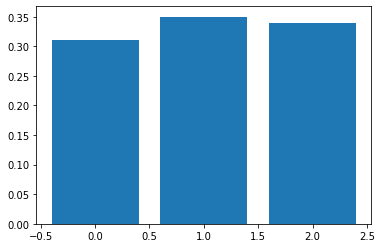

In [10]:
model_1=NBGaussian()
model_1.fit(X_train, y_train)
model_1.plot_pdf()

#### Test wih 1 data record

Label of X_test[10]:  2
Our histogram after update X_test[10]: 


2

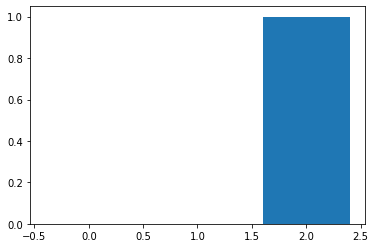

In [11]:
#label of y_test[10]
print('Label of X_test[10]: ', y_test[10])
#update model and show histogram with X_test[10]:

print('Our histogram after update X_test[10]: ')
model_1._predict(X_test[10],plot=True)


#### Evaluate your Gaussian Naive Bayes model

In [12]:
pred=model_1.predict(X_test)
print('Accuracy of your Gaussian Naive Bayes model:', accuracy_score(y_test,pred))


Accuracy of your Gaussian Naive Bayes model: 0.96
